# Preprocessing of data

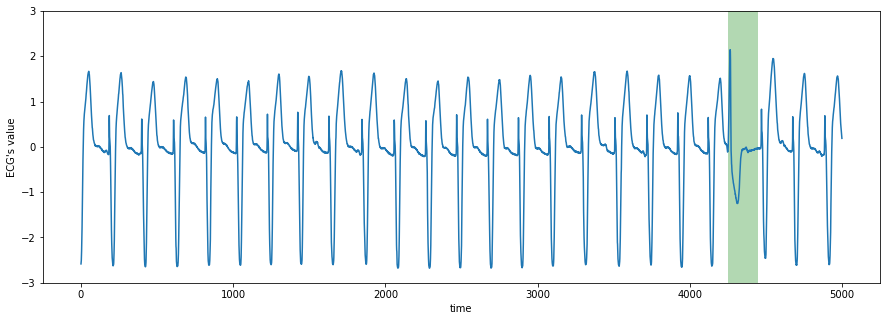

In [2]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

ecg = np.loadtxt("./qtdbsel102.txt")
ecg = ecg[:,2].reshape(len(ecg),-1)

# Standardize
ss = StandardScaler()
ecg_ss = ss.fit_transform(ecg)

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.ylim(-3, 3)
plt.plot(np.arange(5000),ecg_ss[0:5000])
x = np.arange(4250,4450)
y1 = [-3]*len(x)
y2 = [3]*len(x)
plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
plt.show()

# Choose normal data

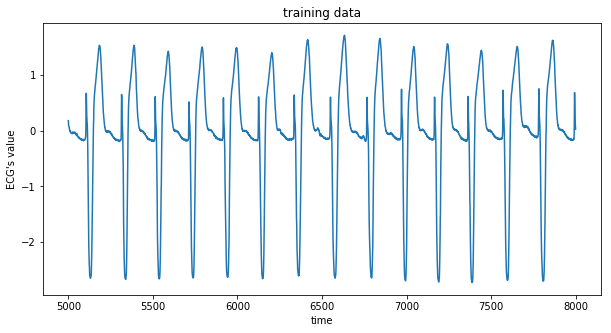

In [3]:
normal = ecg_ss[5000:8000]

plt.figure(figsize=(10,5))
plt.title("training data")
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000,8000), normal[:3000])
plt.show()

# Create past & future set

In [4]:
from sklearn.model_selection import train_test_split

def create_subseq(ts, past_len, pred_len):
    subseq, f_values = [], []
    for i in range(len(ts)-past_len-pred_len):
        subseq.append(ts[i:i+past_len])
        f_values.append(ts[i+past_len:i+past_len+pred_len].T[0])
    return subseq, f_values

past_len = 10
pred_len = 3

subseq, f_values = create_subseq(normal, past_len, pred_len)

X_train, X_test, y_train, y_test = train_test_split(subseq, f_values, test_size=0.2, shuffle=False)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

train_size = X_train.shape[0]
test_size = X_test.shape[0]

print('train size:{}, test size:{}'.format(train_size, test_size))

train size:2389, test size:598


# Definition of model

In [5]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain

np.random.seed(3141592653)

class Model(Chain):
    
    def __init__(self, n_input, n_units, n_output):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.LSTM(n_input, n_units)
            self.l2 = L.LSTM(n_units, n_units)
            self.l3 = L.Linear(n_units, n_output)
    
    def reset_state(self):
        self.l1.reset_state()
        self.l2.reset_state()
        
    def __call__(self, x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        o = self.l3(h2)
        return o

# Optimizer

In [6]:
from chainer import optimizers

model = Model(1, 35, 3)
optimizer = optimizers.Adam()
optimizer.setup(model)

# Parameter settings

In [7]:
batch_size = 100
epoch_number = 1000
period = 20

# Training loop

epoch:1 train loss:0.710966222960016 test loss:0.3420773148536682
epoch:2 train loss:0.29061325995818427 test loss:0.16325974464416504
epoch:3 train loss:0.14354097778382507 test loss:0.09189170598983765
epoch:4 train loss:0.07965868436124014 test loss:0.04948422685265541
epoch:5 train loss:0.04367761475884396 test loss:0.028414256870746613
epoch:6 train loss:0.026974969786470352 test loss:0.020970596000552177
epoch:7 train loss:0.021696802795581196 test loss:0.016287272796034813
epoch:8 train loss:0.01678090761213199 test loss:0.013842755928635597
epoch:9 train loss:0.013601443122910417 test loss:0.010863671079277992
epoch:10 train loss:0.011286666434582161 test loss:0.00932260975241661
epoch:11 train loss:0.009911058774298948 test loss:0.008192956447601318
epoch:12 train loss:0.009226273279637098 test loss:0.007755755912512541
epoch:13 train loss:0.008518671637158031 test loss:0.007437713444232941
epoch:14 train loss:0.007923242301963593 test loss:0.007647598162293434
epoch:15 train 

epoch:113 train loss:0.0029328414593296852 test loss:0.0026104801800101995
epoch:114 train loss:0.00288705851720727 test loss:0.0026470201555639505
epoch:115 train loss:0.002794431861611488 test loss:0.0027109968941658735
epoch:116 train loss:0.002853297431062421 test loss:0.0026024263352155685
epoch:117 train loss:0.0029817833312098746 test loss:0.002739614574238658
epoch:118 train loss:0.002828077266357191 test loss:0.0026664696633815765
epoch:119 train loss:0.0029223878948908787 test loss:0.0029258159920573235
epoch:120 train loss:0.0031024851411095133 test loss:0.0025707525201141834
time:0:00:16.218231
epoch:121 train loss:0.002841570179241345 test loss:0.002704384969547391
epoch:122 train loss:0.0028073850249790626 test loss:0.0025592658203095198
epoch:123 train loss:0.0027671807506324158 test loss:0.0025120999198406935
epoch:124 train loss:0.0029587321965347814 test loss:0.003526984015479684
epoch:125 train loss:0.003221917087617128 test loss:0.002519517205655575
epoch:126 train 

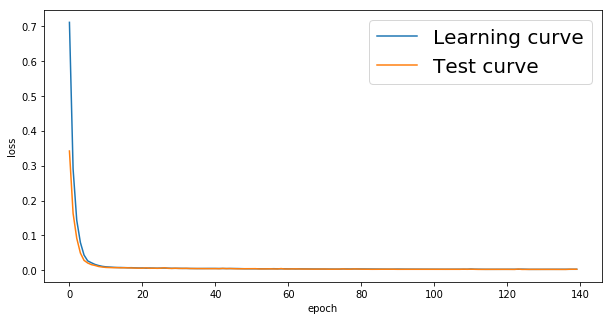

In [8]:
import datetime
from chainer import Variable
from copy import deepcopy

loss_prev = np.inf
st = datetime.datetime.now()
epoch = 0

l_c, t_c = [], []
for epoch in range(epoch_number):
    sffindx = np.random.permutation(train_size)
    train_loss = 0
    
    for i in range(train_size // batch_size):
        batch_X = Variable(X_train[sffindx[i*batch_size:(i+1)*batch_size]])
        batch_y = Variable(y_train[sffindx[i*batch_size:(i+1)*batch_size]])

        for j in range(past_len):
            loss = F.mean_squared_error(model(batch_X[:,j]), batch_y)
            
        model.reset_state()
        model.cleargrads()
        loss.backward()
        optimizer.update()
        train_loss += loss.data
        
    train_loss /= (train_size // batch_size)
    l_c.append(train_loss)
    
    with chainer.using_config("train", False):
        for j in range(past_len):
            loss = F.mean_squared_error(model(Variable(X_test[:,j])), Variable(y_test))
            
        model.reset_state()
        test_loss = loss.data
        t_c.append(test_loss)
        print("epoch:{} train loss:{} test loss:{}".format(epoch+1, train_loss, test_loss))
        
    if (epoch+1) % period == 0:
        ed = datetime.datetime.now()
        print("time:{}".format(ed-st))
        st = datetime.datetime.now()
        if test_loss > loss_prev * 0.99:
            print("Stop Learning")
            break
        else:
            loss_prev = deepcopy(test_loss)
            
plt.figure(figsize=(10,5))
plt.plot(l_c, label='Learning curve')
plt.plot(t_c, label='Test curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(fontsize=20)
plt.show()

# Compute error

In [9]:
for j in range(past_len):
    pred = model(X_test[:,j])

model.reset_state()
error = y_test - pred

mean = sum(error)/len(error)

cov = 0
for i in error:
    cov += F.matmul((i-mean).reshape(len(i),1), (i-mean).reshape(1,len(i)))
cov /= len(error)

print("mean:", mean)
print("covariance:", cov)

mean: variable([-0.00321454 -0.00681216 -0.00072693])
covariance: variable([[0.00103784 0.00115988 0.00085697]
          [0.00115988 0.00274145 0.0029649 ]
          [0.00085697 0.0029649  0.00508462]])


# Anomaly detection

In [10]:
# Mahalanobis distance
def M_dis(x, mean, cov):
    d = F.matmul(x-mean, F.inv(cov))
    d = F.matmul(d, (x-mean).T)
    return d

# Anomaly detection
subseq, f_values = create_subseq(ecg_ss[0:5000], past_len, pred_len)
subseq = np.array(subseq).astype(np.float32)
f_values = np.array(f_values).astype(np.float32)

for j in range(past_len):
    pred = model(subseq[:,j])

model.reset_state()
error = f_values - pred

# Plot

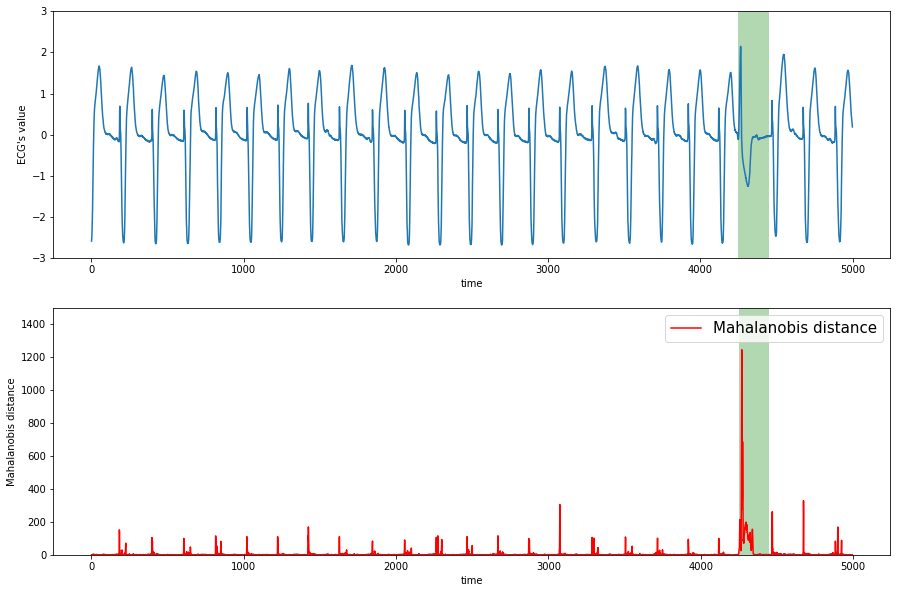

In [11]:
m_dis = [0]*past_len
for i in error:
    m_dis.append(M_dis(i, mean, cov).data)
    
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(ecg_ss[0:5000], label="original data")
axes[0].set_xlabel("time")
axes[0].set_ylabel("ECG\'s value")
axes[0].set_ylim(-3, 3)
x = np.arange(4250,4450)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dis, color="r", label="Mahalanobis distance")
axes[1].set_xlabel("time")
axes[1].set_ylabel("Mahalanobis distance")
axes[1].set_ylim(0, 1500)
y1 = [0]*len(x)
y2 = [1500]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()